In [1]:
#Import modules
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import patches, text, patheffects
import cv2
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
import scipy.cluster.hierarchy as hcluster
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import scipy.stats

In [2]:
def group_DBSCAN(df):
    x = df[["c_x", "c_y"]].to_numpy()
    cluster = DBSCAN(eps=15, min_samples=5).fit(x)
    labels = cluster.labels_
    df["cluster_id"] = labels
    return labels
    #n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    #n_noise_ = list(labels).count(-1)
    
    #EVENTUALLY: run DBSCAN, or sort for running H-Cluster if DBSCAN gives a bad result
    #hcluster = []
    #comp = int(len(df)) / len(((df["labeler_id"].unique())))
    #decision = comp / int(n_clusters_)
    #if decision > 0.9:
    #    df["cluster_id"] = labels
    #    return labels
    #else:
    #    hcluster.append(df["filename"])
    #    return hcluster

In [ ]:
#Needs more work later-- will require different method to define labels
def group_Hcluster(df):
    data = df["centers"]
    thresh = 14
    hclusters = hcluster.fclusterdata(data, thresh, criterion="distance")


In [2]:
#JSON file with all DGC labels
labelpath = r"/Users/rowanconverse/Library/CloudStorage/OneDrive-UniversityofNewMexico/CV4Ecology/Prototyping/Data/Labels/coco/20220227_dgc.json"
with open(labelpath) as f:
  df = pd.read_json(f)
  #cocozoo = pd.read_json(f) #delete this and use above instead once ready to run with all images

In [14]:
#Seagull labels
labelpath = r"/Users/rowanconverse/Library/CloudStorage/OneDrive-UniversityofNewMexico/CV4Ecology/Prototyping/Data/Labels/coco/20220227_seagull.json"
with open(labelpath) as f:
  df = pd.read_json(f)

In [3]:
df["basefile"] = [x[:-10] for x in df['filename']]
df.head()
sub = df[df["basefile"] == "BDA_18a4_20181106_2_00298"]
#len(sub["cluster_id"].value_counts())

#print(len(df))
#print(len(df["filename"].unique()))
#print(df["category"].value_counts())

In [6]:
print(len(sub) / len(sub["labeler_id"].unique()))
#sub.groupby("labeler_id").count()

7.962162162162162


In [6]:
#Directory of test images
imgpath = r"/Users/rowanconverse/Library/CloudStorage/OneDrive-UniversityofNewMexico/CV4Ecology/Prototyping/Data/Imagery/SB597/scratch/test"
imglist = os.listdir(imgpath)

#Creating a multi-image subset to work with (delete this for full version)
df = cocozoo[cocozoo["filename"].isin(imglist)]


In [23]:
#CREATE NEW COLUMNS FOR INPUT INTO DBSCAN

#Derive bounding box centers
bboxes = df["bbox"]
c_x = []
c_y = []
x = []
y = []
w = []
h = []
centers = []
for coord in bboxes:
    center = (coord[0]+(coord[2]/2), coord[1]+(coord[3]/2))
    c_x.append(center[0])
    c_y.append(center[1])
    x.append(coord[0])
    y.append(coord[1])
    w.append(coord[2])
    h.append(coord[3])
    centers.append(center)
#Make these centers into a coordinate format
coords = []
for row in centers:
    coord = list(row)
    coords.append(coord)
#Append new columns to dataframe for manipulating later
df["c_x"] = c_x
df["c_y"] = c_y
df['x'] = x
df['y'] = y
df['w'] = w
df['h'] = h

In [24]:
clusters = df.groupby("filename").apply(lambda x: group_DBSCAN(x))
clusters = clusters.reset_index()
clusters.rename(columns = {0:'cluster_id'}, inplace=True)
long = clusters.explode("cluster_id")
long.reset_index()

,index,filename,cluster_id
0,0,20211201_Atrisco_0459_01_01.png,0
1,0,20211201_Atrisco_0459_01_01.png,1
2,0,20211201_Atrisco_0459_01_01.png,8
3,0,20211201_Atrisco_0459_01_01.png,2
4,0,20211201_Atrisco_0459_01_01.png,3
...,...,...,...
1192464,27884,mxw_L13_20181215_1_05_05.png,10
1192465,27884,mxw_L13_20181215_1_05_05.png,6
1192466,27884,mxw_L13_20181215_1_05_05.png,5
1192467,27884,mxw_L13_20181215_1_05_05.png,1


In [25]:
filesort = df.sort_values(["filename", "annotation_id"])
filesort.reset_index()
test = filesort.reset_index().merge(long.reset_index(), left_index=True, right_index=True, how='left')
test = test.drop(columns=['filename_y','index_y'])
test = test.rename(columns={'filename_x':'filename', 'index_x': 'index'})
test.head()

,index,annotation_id,bbox,area,category_id,category,image_id,filename,labeler_id,c_x,c_y,x,y,w,h,cluster_id
0,956322,956323,"[616.8966064453125, 247.40164184570312, 78.357...",7410.300964,3,Duck,28077,20211201_Atrisco_0459_01_01.png,4721,656.075562,294.686600,616.896606,247.401642,78.357910,94.569916,0
1,956323,956324,"[555.4261474609375, 212.951171875, 53.36450195...",4614.104467,3,Duck,28077,20211201_Atrisco_0459_01_01.png,4721,582.108398,256.183136,555.426147,212.951172,53.364502,86.463928,1
2,956324,956325,"[351.4253234863281, 212.2756805419922, 69.5764...",7707.811369,3,Duck,28077,20211201_Atrisco_0459_01_01.png,4721,386.213547,267.666634,351.425323,212.275681,69.576447,110.781906,8
3,956325,956326,"[261.58392333984375, 108.92428588867188, 66.87...",6369.484280,3,Duck,28077,20211201_Atrisco_0459_01_01.png,4721,295.021149,156.546989,261.583923,108.924286,66.874451,95.245407,2
4,956326,956327,"[174.44451904296875, 22.46035385131836, 61.470...",5190.405317,3,Duck,28077,20211201_Atrisco_0459_01_01.png,4721,205.179733,64.679071,174.444519,22.460354,61.470428,84.437435,3


In [18]:
test["category_id"].value_counts()

2    152538
1     56358
3     39065
4      8871
Name: category_id, dtype: int64

In [27]:
#REFINEMENT STEP: DUCK, GOOSE, CRANE

#Dictionary of category values
categories = {1: "Crane", 2: 'Goose', 3:'Duck', 4: 'Other Bird'}

#Derive refined products: median coordinates, and plurality vote class ID
refined = test.groupby(['filename', 'cluster_id']).agg({'x':'median', 
                         'y':'median', 
                         'w':'median', 
                         'h': 'median',
                         'category_id': pd.Series.mode}).reset_index()
#Make median bounding box into its own column in list form
refined['bbox']= refined[['x','y','w','h']].values.tolist()
#Remove rows where no agreement was reached on class ID
rowcount = len(refined)
refined_drop = refined[refined['category_id'].isin([1,2,3,4])]
agreement = len(refined_drop)
removed = rowcount - agreement
#Remove noise points
refined_id = refined_drop[refined_drop['cluster_id'] != -1]
final = len(refined_id)
noise = rowcount - final
print("Removed rows: %s due to no class ID agreement; %s noise points" %(removed, noise))
refined_id['category'] = refined_id["category_id"].map(categories)
refined_id = refined_id.drop(columns=['x','y','w','h'])

Removed rows: 1975 due to no class ID agreement; 24345 noise points


/var/folders/21/q9_tvtjj53n6mfprd_174cz00000gn/T/ipykernel_18695/511992510.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  refined_id['category'] = refined_id["category_id"].map(categories)


In [28]:
print(len(refined_id))

124547


In [19]:
#REFINEMENT STEP: DGC, SEAGULL

#Dictionary of category values
categories = {1: "Goose", 2: 'Seagull', 3:'Duck', 4:'Crane'}

#Derive refined products: median coordinates, and plurality vote class ID
refined = test.groupby(['filename', 'cluster_id']).agg({'x':'median', 
                         'y':'median', 
                         'w':'median', 
                         'h': 'median',
                         'category_id': pd.Series.mode}).reset_index()
#Make median bounding box into its own column in list form
refined['bbox']= refined[['x','y','w','h']].values.tolist()
#Remove rows where no agreement was reached on class ID
#rowcount = len(refined)
#refined_drop = refined[refined['category_id'].isin([1,2,3,4])]
#agreement = len(refined_drop)
#removed = rowcount - agreement
#Remove noise points
#refined_id = refined_drop[refined_drop['cluster_id'] != -1]
#final = len(refined_id)
#noise = rowcount - final
#print("Removed rows: %s due to no class ID agreement; %s noise points" %(removed, noise))
#refined_id['category'] = refined_id["category_id"].map(categories)
refined_id = refined.drop(columns=['x','y','w','h'])

In [20]:
#EXPORT OF REFINED RESULTS FOR USE AS TRAIN/VAL/TEST (not split yet; determine split after getting class/site stats)

#drop "cluster ID" column
export = refined_id.drop(columns="cluster_id")
#save to csv
exportpath = "/Users/rowanconverse/Library/CloudStorage/OneDrive-UniversityofNewMexico/Dissertation/1_Chapter/consensus/data/"
exportconsensus = datetime.now().strftime('%Y%m%d_zooniverseconsensuslabels_seagull_nodrops.csv')
export.to_csv(exportpath+exportconsensus)

In [21]:
#Create and clean analysis dataframe
df_analysis = test.merge(refined_id, left_on=['filename','cluster_id'], right_on = ['filename','cluster_id'], how='left')
df_analysis = df_analysis.drop(columns=['c_x','c_y','area','x','y','w','h'])
df_analysis = df_analysis.rename(columns={'bbox_x': 'bbox_orig', 'category_id_x': 'cat_id_orig', "category_x": "cat_orig", 'bbox_y': 'bbox_refined', 'category_id_y': 'cat_id_refined', "category_y": "cat_refined"})

#Export to CSV
analysispath = "/Users/rowanconverse/Library/CloudStorage/OneDrive-UniversityofNewMexico/Dissertation/1_Chapter/consensus/data/"
exportanalysis = datetime.now().strftime('%Y%m%d_zooniverseanalysislabels_seagull_nodrops.csv')
df_analysis.to_csv(analysispath+exportanalysis)


In [13]:
df_analysis.head()

,index,annotation_id,bbox_orig,cat_id_orig,category,image_id,filename,labeler_id,cluster_id,cat_id_refined,bbox_refined
0,956322,956323,"[616.8966064453125, 247.40164184570312, 78.357...",3,Duck,28077,20211201_Atrisco_0459_01_01.png,4721,0,2,"[634.05224609375, 260.4735412597656, 49.0, 80...."
1,956323,956324,"[555.4261474609375, 212.951171875, 53.36450195...",3,Duck,28077,20211201_Atrisco_0459_01_01.png,4721,1,2,"[555.4261474609375, 216.25, 53.0, 69.0]"
2,956324,956325,"[351.4253234863281, 212.2756805419922, 69.5764...",3,Duck,28077,20211201_Atrisco_0459_01_01.png,4721,8,2,"[369.28125, 237.5530014038086, 61.433685302734..."
3,956325,956326,"[261.58392333984375, 108.92428588867188, 66.87...",3,Duck,28077,20211201_Atrisco_0459_01_01.png,4721,2,2,"[266.75, 120.83124542236328, 60.33087158203125..."
4,956326,956327,"[174.44451904296875, 22.46035385131836, 61.470...",3,Duck,28077,20211201_Atrisco_0459_01_01.png,4721,3,2,"[176.8125, 22.46035385131836, 52.0, 84.0]"


In [133]:
len(export)

22810

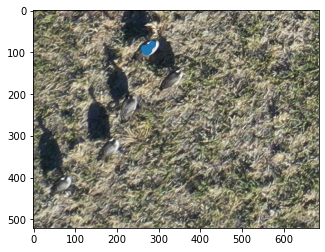

In [ ]:
#Visualize one from "test" to see if the correct clusters seem to have been attached
img = "20211201_Atrisco_0465_07_01.png"
subset = test[test["filename"] == img]
onecluster = subset.loc[subset["cluster_id"] == 0]

# x_df = []
# y_df = []
# for coord in subset["centers"]:
#     x1 = coord[0]
#     x_df.append(x1)
#     y1 = coord[1]
#     y_df.append(y1)

fig, ax = plt.subplots()
img = cv2.imread(imgpath+"/20211201_Atrisco_0465_07_01.png")
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
ax.imshow(img)
ax.scatter(onecluster["c_x"],onecluster["c_y"])

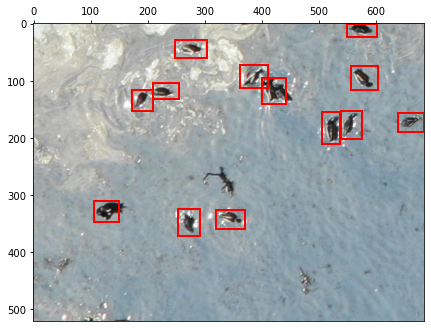

In [ ]:
#Checking that refined bounding boxes appear as expected
testimg = "FWS_MaxwellLake13_20171215_1_00613_02_03.png"
subset = refined_id[refined_id["filename"] == testimg]
img = cv2.imread(imgpath+"/"+testimg)
#onecluster = subset.loc[subset["cluster_id"] == 0]

bboxes = list(subset["bbox"])

def get_bb(bboxes, img):  
    boxes = bboxes.copy()
    
    return np.squeeze(boxes)

def img_show(img, ax = None, figsize=(7,11)):
  if ax is None: fig, ax = plt.subplots(figsize=figsize)
  ax.xaxis.tick_top()
  ax.imshow(img)  
  return ax

def draw_box(img, ax, bb):
  patch = ax.add_patch(patches.Rectangle((bb[0],bb[1]), bb[2], bb[3], fill=False, edgecolor='red', lw=2))
  
def plot_sample(img,bboxes, ax=None, figsize=(7,11)):
  bb = get_bb(bboxes, img)
  ax = img_show(img, ax=ax)
  for i in range(len(bboxes)):
    draw_box(img,ax,bb[i])

plot_sample(img,bboxes)